# Points of Interest (Museums, BBQ Joints, and Coffee Shops)

In [247]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import geonamescache

# Import API key 
from config import geoapify_key

In [263]:
# initialize GeonamesCache
gc = geonamescache.GeonamesCache()

# Get the states and cities from the GeonamesCache object
states = gc.get_us_states()
cities = gc.get_cities()

# Convert the cities dictionary to a dataframe
cities_in_states_df = pd.DataFrame(list(cities.values()), columns=list(cities.values())[0].keys())

# Filter the dataframe to only include cities in Texas, Michigan, and California
cities_in_states_df = cities_in_states_df[cities_in_states_df['admin1code'].isin(['CA', 'MI', 'TX'])]

cities_in_states_df.head()


,geonameid,name,latitude,longitude,countrycode,population,timezone,admin1code,alternatenames
22802,4669635,Abilene,32.44874,-99.73314,US,121721,America/Chicago,TX,"[ABI, Abilenas, Abilene, Abilin, Abilina, Abil..."
22803,4669828,Addison,32.96179,-96.82917,US,15518,America/Chicago,TX,"[ADS, Adison, adyswn, adyswn tgzas, Адисон, آ..."
22804,4670074,Alamo,26.18369,-98.12306,US,19246,America/Chicago,TX,"[Alamo, Ebenezer, Swallow]"
22805,4670146,Aldine,29.93245,-95.38021,US,15869,America/Chicago,TX,[]
22806,4670234,Alice,27.75225,-98.06972,US,19408,America/Chicago,TX,"[ALI, Alice, Alis, Bandana, alys, alys tgzas,..."


In [268]:
# Create a new dataframe holding only the population data for the states of Texas, California, and Michigan
state_population_df = cities_in_states_df[["name", "admin1code", "population"]].copy()

# Rename columns for clarity
state_population_df.rename(columns={'name': 'City', 'population': 'Population', 'admin1code': 'State'}, inplace=True)

state_population_df = state_population_df.groupby('State').agg({'Population': 'sum'})

state_population_df

,Population
State,
CA,35585967
MI,4378548
TX,18275971


In [249]:
# Rename columns for clarity
cities_in_states_df.rename(columns={'name': 'City', 'latitude': 'Latitude', 'longitude': 'Longitude',
                                     'population': 'Population', 'admin1code': 'State'}, inplace=True)

# Drop unnecessary columns
cities_in_states_df.drop(['geonameid', 'timezone', 'alternatenames', 'countrycode'], axis=1, inplace=True)

# Label index column
cities_in_states_df.index.rename('ID', inplace=True)

# Remove cities smaller than 100,000
cities_in_states_df = cities_in_states_df[cities_in_states_df["Population"] > 500000]

# Reorder the columns
cities_in_states_df = cities_in_states_df[['Latitude', 'Longitude', 'City', 'State', 'Population']]

# Export the cities_in_states_df into a csv
cities_in_states_df.to_csv("cities_in_states.csv", index_label="ID")

cities_in_states_df

,Latitude,Longitude,City,State,Population
ID,,,,,
22814,30.26715,-97.74306,Austin,TX,931830
22847,32.78306,-96.80667,Dallas,TX,1300092
22861,32.72541,-97.32085,Fort Worth,TX,918915
22878,29.76328,-95.36327,Houston,TX,2296224
22939,29.42412,-98.49363,San Antonio,TX,1469845
23523,42.33143,-83.04575,Detroit,MI,677116
24413,36.74773,-119.77237,Fresno,CA,520052
24483,34.05223,-118.24368,Los Angeles,CA,3971883
24596,32.71571,-117.16472,San Diego,CA,1394928


In [250]:
%%capture --no-display

cities_in_states_map = cities_in_states_df.hvplot.points(
    x='Longitude',
    y='Latitude',
    geo=True,
    size=cities_in_states_df["Population"] * 0.001, #Size of plots are in relation to population size of city
    ###need to figure out how to exclude size from the hover box
    hover_cols=['City', 'State'],
    color='City',
    tiles=True,
    alpha=0.4,
    width=900,
    height=500
)

cities_in_states_map

####figure out how to use geojson to outline each state

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (City,_size,State)

#### Add in Museums

In [251]:
# Use the Pandas copy function to create DataFrame for museums
museum_df = cities_in_states_df[["Latitude", "Longitude", "City", "State", "Population"]].copy()

# Add an empty column, "Museum" to the DataFrame so you can store the museum name found using the Geoapify API
museum_df["Museum"] = ""

# Display sample data
museum_df.head()

,Latitude,Longitude,City,State,Population,Museum
ID,,,,,,
22814,30.26715,-97.74306,Austin,TX,931830,
22847,32.78306,-96.80667,Dallas,TX,1300092,
22861,32.72541,-97.32085,Fort Worth,TX,918915,
22878,29.76328,-95.36327,Houston,TX,2296224,
22939,29.42412,-98.49363,San Antonio,TX,1469845,


In [252]:
# Set parameters to search for museums
radius = 10 * 1609.344 #to convert to miles ###would love this to be imperial, but units isn't a param
params = {
    "categories":"entertainment.museum",
    "apiKey": geoapify_key,
    "limit": 300
}

# Print a message to follow up the museum search
print("Starting museum search")

# Iterate through the poi_df DataFrame
for index, row in museum_df.iterrows():
    # get latitude, longitude from the DataFrame
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    
    # Add the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"
    params["bias"] = f"proximity:{longitude},{latitude}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"
    
# Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    
    # Store the number of museums in the response in a new column in the DataFrame
    museum_df.loc[index, "Num of Museums"] = len(name_address["features"])
    
    # Grab the first museum from the results and store the name in the museum_df DataFrame
    try:
        museum_df.loc[index, "Museum"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no museum is found, set the museum name as "No museum found".
        museum_df.loc[index, "Museum"] = "No museum found"
        
    # Log the search results
    print(f"{museum_df.loc[index, 'City']} - nearest museum: {museum_df.loc[index, 'Museum']} - Number of museums in radius: {museum_df.loc[index, 'Num of Museums']}")

# Display sample data
museum_df

Starting museum search
Austin - nearest museum: Mexic-Arte Museum - Number of museums in radius: 32.0
Dallas - nearest museum: American Museum of the Miniature Arts - Number of museums in radius: 17.0
Fort Worth - nearest museum: JUNETEENTH MUSEUM - Number of museums in radius: 31.0
Houston - nearest museum: Harris County Heritage Society Museum - Number of museums in radius: 23.0
San Antonio - nearest museum: Spanish Governor's Palace - Number of museums in radius: 61.0
Detroit - nearest museum: William V. Banks Broadcast Museum & Media Center - Number of museums in radius: 30.0
Fresno - nearest museum: Meux Home Museum - Number of museums in radius: 4.0
Los Angeles - nearest museum: Union Center for the Arts - Number of museums in radius: 118.0
San Diego - nearest museum: Museum of Contemporary Art - Number of museums in radius: 51.0
San Francisco - nearest museum: Asian Art Museum of San Francisco - Number of museums in radius: 84.0
San Jose - nearest museum: Carmel and Thomas Fallo

,Latitude,Longitude,City,State,Population,Museum,Num of Museums
ID,,,,,,,
22814,30.26715,-97.74306,Austin,TX,931830,Mexic-Arte Museum,32.0
22847,32.78306,-96.80667,Dallas,TX,1300092,American Museum of the Miniature Arts,17.0
22861,32.72541,-97.32085,Fort Worth,TX,918915,JUNETEENTH MUSEUM,31.0
22878,29.76328,-95.36327,Houston,TX,2296224,Harris County Heritage Society Museum,23.0
22939,29.42412,-98.49363,San Antonio,TX,1469845,Spanish Governor's Palace,61.0
23523,42.33143,-83.04575,Detroit,MI,677116,William V. Banks Broadcast Museum & Media Center,30.0
24413,36.74773,-119.77237,Fresno,CA,520052,Meux Home Museum,4.0
24483,34.05223,-118.24368,Los Angeles,CA,3971883,Union Center for the Arts,118.0
24596,32.71571,-117.16472,San Diego,CA,1394928,Museum of Contemporary Art,51.0


In [253]:
%%capture --no-display

museum_map = museum_df.hvplot.points(
    x='Longitude',
    y='Latitude',
    geo=True,
    size=cities_in_states_df['Population'] * 0.001, #Size of plots are in relation to population size of city
    ###need to figure out how to exclude size from the hover box
    hover_cols=['City', 'State', 'Museum', 'Num of Museums', 'Population'],
    color='City',
    tiles=True,
    alpha=0.4,
    width=900,
    height=500
)

museum_map

####figure out how to use geojson to outline each state

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (City,_size,State,Museum,Num of Museums,Population)

#### Add in BBQ Restaurants

In [254]:
# Use the Pandas copy function to create DataFrame for museums and bbq joints
bbq_df = museum_df[["Latitude", "Longitude", "City", "State", "Population", "Museum", "Num of Museums"]].copy()

# Add an empty column, "BBQ Joints" to the DataFrame so you can store the BBQ joint name found using the Geoapify API
bbq_df["BBQ Joints"] = ""

# Display sample data
bbq_df.head()

,Latitude,Longitude,City,State,Population,Museum,Num of Museums,BBQ Joints
ID,,,,,,,,
22814,30.26715,-97.74306,Austin,TX,931830,Mexic-Arte Museum,32.0,
22847,32.78306,-96.80667,Dallas,TX,1300092,American Museum of the Miniature Arts,17.0,
22861,32.72541,-97.32085,Fort Worth,TX,918915,JUNETEENTH MUSEUM,31.0,
22878,29.76328,-95.36327,Houston,TX,2296224,Harris County Heritage Society Museum,23.0,
22939,29.42412,-98.49363,San Antonio,TX,1469845,Spanish Governor's Palace,61.0,


In [255]:
# Set parameters to search for BBQ joints
radius = 10 * 1609.344 #to convert to miles ###would love this to be imperial, but units isn't a param
params = {
    "categories":"catering.restaurant.barbecue",
    "apiKey": geoapify_key,
    "limit": 100
}

# Print a message to follow up the BBQ search
print("Starting BBQ search")

# Iterate through the poi_df DataFrame
for index, row in bbq_df.iterrows():
    # get latitude, longitude from the DataFrame
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    
    # Add the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"
    params["bias"] = f"proximity:{longitude},{latitude}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"
    
# Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()

    # Create an empty list to store the names of the BBQ joints
    bbq_names = []
    
    # Store the number of BBQ in the response in a new column in the DataFrame
    bbq_df.loc[index, "Num of BBQ Joints"] = len(name_address["features"])
    
    # Grab the first BBQ from the results and store the name in the bbq_df DataFrame
    try:
        bbq_df.loc[index, "BBQ Joints"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no BBQ is found, set the BBQ name as "No BBQ found".
        bbq_df.loc[index, "BBQ Joints"] = "No BBQ found"
        
    # Log the search results
    print(f"{bbq_df.loc[index, 'City']} - nearest BBQ Joint: {bbq_df.loc[index, 'BBQ Joints']} - Number of BBQ Joints in radius: {bbq_df.loc[index, 'Num of BBQ Joints']}")

# Display sample data
bbq_df

###Need to store names of BBQ joints so Fort Worth doesn't say it has no BBQ joints

Starting BBQ search
Austin - nearest BBQ Joint: Cooper's Old Time Pit Bar-B-Que - Number of BBQ Joints in radius: 18.0
Dallas - nearest BBQ Joint: Sonny Bryan's Smokehouse - Number of BBQ Joints in radius: 12.0
Fort Worth - nearest BBQ Joint: No BBQ found - Number of BBQ Joints in radius: 17.0
Houston - nearest BBQ Joint: Pappas BBQ - Number of BBQ Joints in radius: 19.0
San Antonio - nearest BBQ Joint: The County Line - Number of BBQ Joints in radius: 19.0
Detroit - nearest BBQ Joint: BB's Butcher's Inn - Number of BBQ Joints in radius: 7.0
Fresno - nearest BBQ Joint: Famous Dave's - Number of BBQ Joints in radius: 3.0
Los Angeles - nearest BBQ Joint: Kobunga Korean Grill - Number of BBQ Joints in radius: 15.0
San Diego - nearest BBQ Joint: Kansas City Barbeque - Number of BBQ Joints in radius: 4.0
San Francisco - nearest BBQ Joint: Cathead's BBQ - Number of BBQ Joints in radius: 18.0
San Jose - nearest BBQ Joint: Henry’s Hi-Life - Number of BBQ Joints in radius: 24.0
El Paso - neares

,Latitude,Longitude,City,State,Population,Museum,Num of Museums,BBQ Joints,Num of BBQ Joints
ID,,,,,,,,,
22814,30.26715,-97.74306,Austin,TX,931830,Mexic-Arte Museum,32.0,Cooper's Old Time Pit Bar-B-Que,18.0
22847,32.78306,-96.80667,Dallas,TX,1300092,American Museum of the Miniature Arts,17.0,Sonny Bryan's Smokehouse,12.0
22861,32.72541,-97.32085,Fort Worth,TX,918915,JUNETEENTH MUSEUM,31.0,No BBQ found,17.0
22878,29.76328,-95.36327,Houston,TX,2296224,Harris County Heritage Society Museum,23.0,Pappas BBQ,19.0
22939,29.42412,-98.49363,San Antonio,TX,1469845,Spanish Governor's Palace,61.0,The County Line,19.0
23523,42.33143,-83.04575,Detroit,MI,677116,William V. Banks Broadcast Museum & Media Center,30.0,BB's Butcher's Inn,7.0
24413,36.74773,-119.77237,Fresno,CA,520052,Meux Home Museum,4.0,Famous Dave's,3.0
24483,34.05223,-118.24368,Los Angeles,CA,3971883,Union Center for the Arts,118.0,Kobunga Korean Grill,15.0
24596,32.71571,-117.16472,San Diego,CA,1394928,Museum of Contemporary Art,51.0,Kansas City Barbeque,4.0


In [256]:
%%capture --no-display

bbq_map = bbq_df.hvplot.points(
    x='Longitude',
    y='Latitude',
    geo=True,
    size=cities_in_states_df['Population'] * 0.001, #Size of plots are in relation to population size of city
    ###need to figure out how to exclude size from the hover box
    hover_cols=['City', 'State', 'Museum', 'Num of Museums', 'BBQ Joints', 'Num of BBQ Joints', 'Population'],
    color='City',
    tiles=True,
    alpha=0.4,
    width=900,
    height=500
)

bbq_map

####figure out how to use geojson to outline each state

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (City,_size,State,Museum,Num of Museums,BBQ Joints,Num of BBQ Joints,Population)

#### Add in Coffee Shops

In [257]:
# Use the Pandas copy function to create DataFrame for Points of Interest (museums, bbq joints, and coffee shops)
poi_df = bbq_df[["Latitude", "Longitude", "City", "State", "Population", "Museum", "Num of Museums", "BBQ Joints", "Num of BBQ Joints"]].copy()

# Add an empty column, "Coffee Shop" to the DataFrame so you can store the coffee shop name found using the Geoapify API
poi_df["Coffee Shop"] = ""

# Display sample data
poi_df.head()

,Latitude,Longitude,City,State,Population,Museum,Num of Museums,BBQ Joints,Num of BBQ Joints,Coffee Shop
ID,,,,,,,,,,
22814,30.26715,-97.74306,Austin,TX,931830,Mexic-Arte Museum,32.0,Cooper's Old Time Pit Bar-B-Que,18.0,
22847,32.78306,-96.80667,Dallas,TX,1300092,American Museum of the Miniature Arts,17.0,Sonny Bryan's Smokehouse,12.0,
22861,32.72541,-97.32085,Fort Worth,TX,918915,JUNETEENTH MUSEUM,31.0,No BBQ found,17.0,
22878,29.76328,-95.36327,Houston,TX,2296224,Harris County Heritage Society Museum,23.0,Pappas BBQ,19.0,
22939,29.42412,-98.49363,San Antonio,TX,1469845,Spanish Governor's Palace,61.0,The County Line,19.0,


#### Add in Coffee Shops to complete Points of Interests

In [258]:
# Set parameters to search for Coffee Shops
radius = 10 * 1609.344 #to convert to miles ###would love this to be imperial, but units isn't a param
params = {
    "categories":"catering.cafe.coffee_shop",
    "apiKey": geoapify_key,
    "limit": 300
}

# Print a message to follow up the BBQ search
print("Starting Coffee Shop search")

# Iterate through the poi_df DataFrame
for index, row in poi_df.iterrows():
    # get latitude, longitude from the DataFrame
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    
    # Add the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{longitude},{latitude},{radius}"
    params["bias"] = f"proximity:{longitude},{latitude}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"
    
# Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()

    # Create an empty list to store the names of the BBQ joints
    coffee_shops = []
    
    # Store the number of BBQ in the response in a new column in the DataFrame
    poi_df.loc[index, "Num of Coffee Shops"] = len(name_address["features"])
    
    # Grab the first Coffee Shop from the results and store the name in the poi_df DataFrame
    try:
        poi_df.loc[index, "Coffee Shop"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no BBQ is found, set the BBQ name as "No BBQ found".
        poi_df.loc[index, "Coffee Shop"] = "No BBQ found"
        
    # Log the search results
    print(f"{poi_df.loc[index, 'City']} - nearest Coffee Shop: {poi_df.loc[index, 'Coffee Shop']} - Number of Coffee Shops in radius: {poi_df.loc[index, 'Num of Coffee Shops']}")

# Display sample data
poi_df

# Export the poi_df into a csv
poi_df.to_csv("poi_df.csv", index_label="ID")

Starting Coffee Shop search
Austin - nearest Coffee Shop: My Name Is Joe Coffee - Number of Coffee Shops in radius: 71.0
Dallas - nearest Coffee Shop: Starbucks - Number of Coffee Shops in radius: 38.0
Fort Worth - nearest Coffee Shop: Cherry Coffee Shop - Number of Coffee Shops in radius: 30.0
Houston - nearest Coffee Shop: Starbucks - Number of Coffee Shops in radius: 73.0
San Antonio - nearest Coffee Shop: Commonwealth Coffeehouse - Number of Coffee Shops in radius: 40.0
Detroit - nearest Coffee Shop: Roasting Plant - Number of Coffee Shops in radius: 93.0
Fresno - nearest Coffee Shop: Starbucks - Number of Coffee Shops in radius: 13.0
Los Angeles - nearest Coffee Shop: Blue Bottle Coffee - Number of Coffee Shops in radius: 222.0
San Diego - nearest Coffee Shop: Starbucks - Number of Coffee Shops in radius: 128.0
San Francisco - nearest Coffee Shop: Blue Bottle Coffee - Number of Coffee Shops in radius: 281.0
San Jose - nearest Coffee Shop: Voyager Craft Coffee - Number of Coffee Sh

In [259]:
%%capture --no-display

poi_map = poi_df.hvplot.points(
    x='Longitude',
    y='Latitude',
    geo=True,
    size=cities_in_states_df['Population'] * 0.001, #Size of plots are in relation to population size of city
    ###need to figure out how to exclude size from the hover box
    hover_cols=['City', 'State', 'Museum', 'Num of Museums', 'BBQ Joints', 'Num of BBQ Joints', 'Coffee Shop', 'Num of Coffee Shops', 'Population'],
    color='City',
    tiles=True,
    alpha=0.4,
    width=900,
    height=500
)

poi_map

####figure out how to use geojson to outline each state

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (City,_size,State,Museum,Num of Museums,BBQ Joints,Num of BBQ Joints,Coffee Shop,Num of Coffee Shops,Population)

#### Visualizing Points of Interest

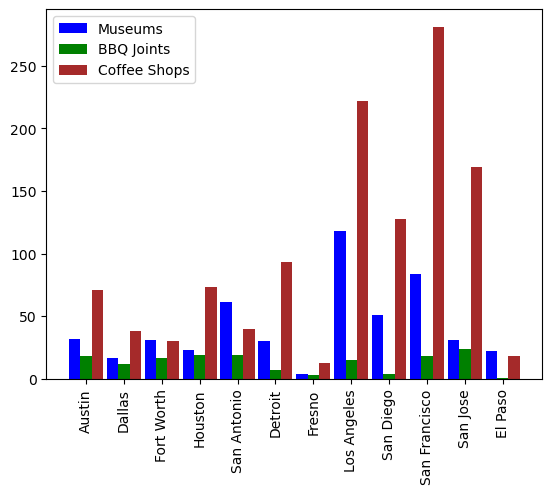

In [260]:
# Bar Chart
# Get the values from the DataFrame
museum_data = poi_df["Num of Museums"]
bbq_data = poi_df["Num of BBQ Joints"]
coffee_data = poi_df["Num of Coffee Shops"]

# set the x-axis labels as the city names
x_axis = poi_df["City"].tolist()

# set the width of the bars
bar_width = 0.3

# set the position of the bars
r1 = range(len(x_axis))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# create the bar chart
fig, ax = plt.subplots()
museums = ax.bar(r1, museum_data, bar_width, color='blue', label='Museums')
bbq = ax.bar(r2, bbq_data, bar_width, color='green', label='BBQ Joints')
coffee = ax.bar(r3, coffee_data, bar_width, color='brown', label='Coffee Shops')

# add the x-axis labels
ax.set_xticks([x + bar_width for x in range(len(x_axis))])
ax.set_xticklabels(x_axis, rotation=90)

# add the legend
ax.legend()

# show the bar chart
plt.show()

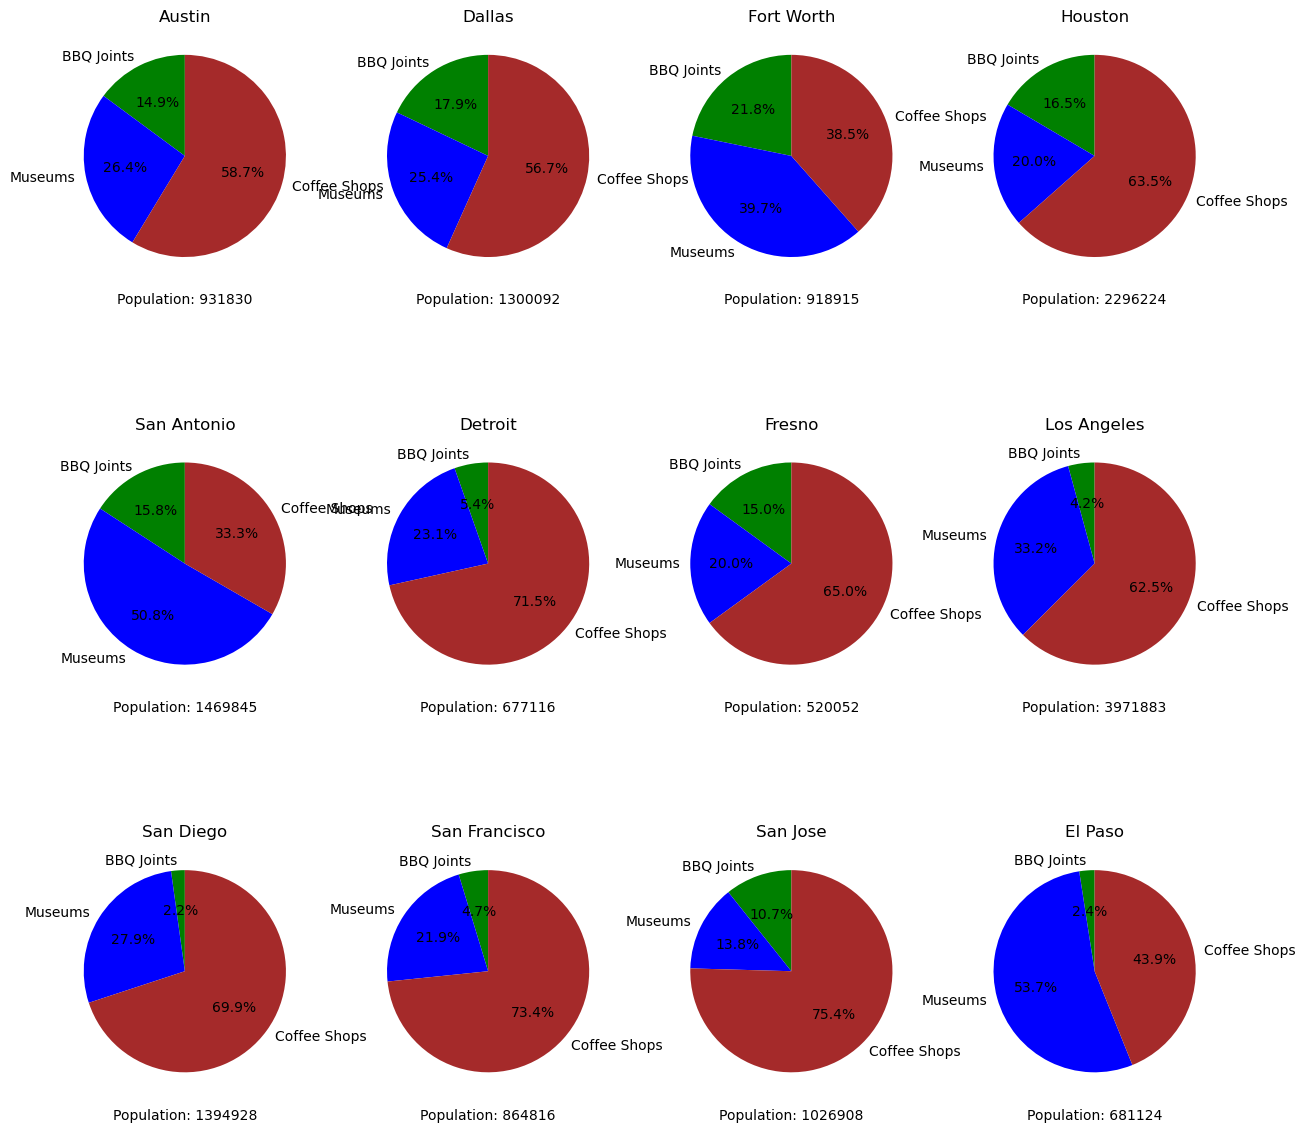

In [261]:
# Pie Charts
# create a figure and axis objects
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 15))

# loop over the poi_df list
for i, (index, city_data) in enumerate(poi_df.iterrows()):
    bbq_data = city_data["Num of BBQ Joints"]
    museum_data = city_data["Num of Museums"]
    coffee_data = city_data["Num of Coffee Shops"]

    # plot the pie chart for the current city
    ax[i//4, i%4].pie([bbq_data, museum_data, coffee_data], labels=["BBQ Joints", "Museums", "Coffee Shops"], 
                     autopct='%1.1f%%', startangle=90, 
                     colors=['green', 'blue', 'brown'])
    ax[i//4, i%4].set_title(city_data["City"])
    ax[i//4, i%4].set_xlabel("Population: {}".format(city_data["Population"]))

# show the plot
plt.show()